# Yelp Data Challenge - Restaurant Recommender


### Flora Li

## Goal
1. Clean data and get rating data: select 'business_id','user_id','stars' columns as df_stars; select users with over 5 comments and restore them into df_stars_cleaned; create utility matrix, which captures users' rating on restaurants.
2. Build recommender systems with graphlab: Item-Item similarity recommender, Matrix Factorization recommender, Content-based recommender and Popularity-based recommender.

___Note for Content-based recommender___: 
1. Extract features for recommender, including average numerical features and categories data
2. Use SVD to reduce dimensions of the sparse matrix generated by categories data
3. Join the numerical features and categories data matrices together to generate feature data for each business_id
4. Build the recommender system to make recommendation for a single item, find the similar items and recommend for a sample user.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('last_2_years_restaurant_reviews1.csv')

In [3]:
df.head()

,business_id,name,categories,avg_stars,cool,date,funny,review_id,stars,text,useful,user_id
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"[Steakhouses, Cajun/Creole, Restaurants]",4.0,1,2016-05-17,0,0Qc1THNHSapDL7cv-ZzW5g,5,What can I say.. Wowzers! Probably one of the ...,0,4LxKRRIikhr65GfPDW626w
1,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"[Steakhouses, Cajun/Creole, Restaurants]",4.0,0,2017-01-20,0,L8lo5SKXfZRlbn1bpPiC9w,5,Went here for guys weekend. Unbelievable. Ravi...,0,nT8zgjoc-PbdBoQsFEXFLw
2,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"[Steakhouses, Cajun/Creole, Restaurants]",4.0,52,2016-09-25,30,6eUT3IwwWPP3CZkAhxqOIw,5,"One word my friends: tableside!!! Yes, tablesi...",56,7RlyCglsIzhBn081inwvcg
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"[Steakhouses, Cajun/Creole, Restaurants]",4.0,1,2017-02-12,0,3cnTdE45VrsS0o4cVhfGog,3,"Located inside my favorite hotel Venetian, Del...",1,rOIrilMC7VFwFVBeQNiKMw
4,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"[Steakhouses, Cajun/Creole, Restaurants]",4.0,0,2016-10-30,0,tYrSbjX3QgZGBZuQ3n8g6w,5,"After the most incredible service, delicious m...",2,PiWlV_UC_-SXqyxQM9fAtw


## 1. Clean data and get rating data 

#### Select relevant columns in the original dataframe

In [4]:
# Get business_id, user_id, stars for recommender

df_stars= df[['business_id','user_id','stars']]

# treat the three columns as a list and select them out

In [5]:
df_stars.head()

,business_id,user_id,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,4LxKRRIikhr65GfPDW626w,5
1,--9e1ONYQuAa-CB_Rrw7Tw,nT8zgjoc-PbdBoQsFEXFLw,5
2,--9e1ONYQuAa-CB_Rrw7Tw,7RlyCglsIzhBn081inwvcg,5
3,--9e1ONYQuAa-CB_Rrw7Tw,rOIrilMC7VFwFVBeQNiKMw,3
4,--9e1ONYQuAa-CB_Rrw7Tw,PiWlV_UC_-SXqyxQM9fAtw,5


In [6]:
# stars distribution
df_stars['stars'].value_counts()

5    158277
4     71123
1     43677
3     37319
2     28177
Name: stars, dtype: int64

We can see that most of the reviews giving 5 stars to the restaurant.

In [7]:
# number of unique business_id
df_stars['business_id'].nunique()

4410

In [8]:
# number of unique user_id
df_stars['user_id'].nunique()

160590

In [9]:
# user comments counts
df_user_count = df_stars['user_id'].value_counts()
df_user_count.head()

bLbSNkLggFnqwNNzzq-Ijw    456
JaqcCU3nxReTW2cBLHounA    296
PKEzKWv_FktMm2mGPjwd0Q    169
B1829_hxXSEpDPEDJtYeIw    158
OXSJCjKtvZPf-YPDCXcWZg    153
Name: user_id, dtype: int64

In [10]:
df_user_count.describe()

count    160590.000000
mean          2.108307
std           3.911094
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         456.000000
Name: user_id, dtype: float64

In [11]:
# number of users with only one comment
len([value for value in df_user_count if value == 1])

105481

We can see that user comments data is extremely right skewed.

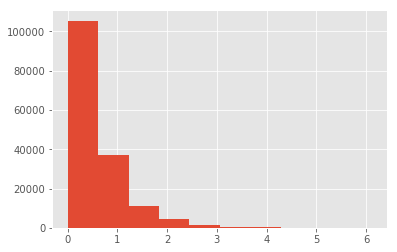

In [12]:
# display log histogram for user comments counts
df_user_count.apply(np.log).hist()
plt.show()

# Because most of users only give 1 comment, so we use log to shrink the range of comments to make the histogram more readable

#### There are many users that haven't given many reviews, exclude these users from the item-item similarity recommender

**Q**: How do we recommend to these users anyways?

In [13]:
# how many users only comments once
df_user_count[df_user_count==1].count()

105481

If number of comments the user gives is too small, it means that in the matrix there are too many missing values for that user. It is similar to a 'cold start', so we drop these kind of users here.

In [14]:
# users comment over 4 times
df_users = df_user_count[df_user_count > 5]
df_users.head()

bLbSNkLggFnqwNNzzq-Ijw    456
JaqcCU3nxReTW2cBLHounA    296
PKEzKWv_FktMm2mGPjwd0Q    169
B1829_hxXSEpDPEDJtYeIw    158
OXSJCjKtvZPf-YPDCXcWZg    153
Name: user_id, dtype: int64

In [15]:
# count users comment over 5 times as active user
df_users.count()

8902

In [16]:
# sum of all comments
df_users.sum()

108088

Total number of comments these active users give is 108k.

In [17]:
# display active user id
df_users.index

Index([u'bLbSNkLggFnqwNNzzq-Ijw', u'JaqcCU3nxReTW2cBLHounA',
       u'PKEzKWv_FktMm2mGPjwd0Q', u'B1829_hxXSEpDPEDJtYeIw',
       u'OXSJCjKtvZPf-YPDCXcWZg', u'U4INQZOPSUaj8hMjLlZ3KA',
       u'3nIuSCZk5f_2WWYMLN7h3w', u'JQIZhoQB-Tg9hdBEj90m4g',
       u'qPVtjjp8sNQ32p9860SR9Q', u'zH6racrZ7rUqqv_Qy6dZDQ',
       ...
       u'5guGdvueiuyhLOyRKJG8lQ', u'8cuaubMlBl-_5daO2rlDKQ',
       u'jRKYNeAyiDlHSI3pOQaPUw', u'4otKBCcoTLy-xiiEsTNJWw',
       u'ot3m-jIwFMFFCMG1bkLZgQ', u'S2h7RSsYxhohFvzfk-QcHg',
       u'ENob_LVAk-FqNJ5-PB5Ufg', u'OvSvbUCHdtto3CXK1EwTxA',
       u'1ug7EtH4blOzzbqqkmkenA', u'yyp13q8IDxLZKGS3xzB6ww'],
      dtype='object', length=8902)

In [18]:
#df_stars.head()
df_stars.set_index('user_id').head()     # set user_id as index

,business_id,stars
user_id,,
4LxKRRIikhr65GfPDW626w,--9e1ONYQuAa-CB_Rrw7Tw,5
nT8zgjoc-PbdBoQsFEXFLw,--9e1ONYQuAa-CB_Rrw7Tw,5
7RlyCglsIzhBn081inwvcg,--9e1ONYQuAa-CB_Rrw7Tw,5
rOIrilMC7VFwFVBeQNiKMw,--9e1ONYQuAa-CB_Rrw7Tw,3
PiWlV_UC_-SXqyxQM9fAtw,--9e1ONYQuAa-CB_Rrw7Tw,5


In [19]:
# Order the data based on user_id
df_stars.set_index('user_id').loc[df_users.index].head()

,business_id,stars
user_id,,
bLbSNkLggFnqwNNzzq-Ijw,-C8sSrFqaCxp51pyo-fQLQ,4
bLbSNkLggFnqwNNzzq-Ijw,-CQokjildrY7UZezXCdEBw,5
bLbSNkLggFnqwNNzzq-Ijw,-FcZY7a7qgxTUlTvwuyJnQ,3
bLbSNkLggFnqwNNzzq-Ijw,-IWsoxH7mLJTTpU5MmWY4w,4
bLbSNkLggFnqwNNzzq-Ijw,-NjZ5HZApXjRJaTVZeSO_w,4


In [20]:
# reorder dataframe
df_stars_cleaned = df_stars.set_index('user_id').loc[df_users.index].reset_index()

print (df_stars.head())
print (df_stars_cleaned.head())   # The dataframe is reorderd based on user-id

              business_id                 user_id  stars
0  --9e1ONYQuAa-CB_Rrw7Tw  4LxKRRIikhr65GfPDW626w      5
1  --9e1ONYQuAa-CB_Rrw7Tw  nT8zgjoc-PbdBoQsFEXFLw      5
2  --9e1ONYQuAa-CB_Rrw7Tw  7RlyCglsIzhBn081inwvcg      5
3  --9e1ONYQuAa-CB_Rrw7Tw  rOIrilMC7VFwFVBeQNiKMw      3
4  --9e1ONYQuAa-CB_Rrw7Tw  PiWlV_UC_-SXqyxQM9fAtw      5
                  user_id             business_id  stars
0  bLbSNkLggFnqwNNzzq-Ijw  -C8sSrFqaCxp51pyo-fQLQ      4
1  bLbSNkLggFnqwNNzzq-Ijw  -CQokjildrY7UZezXCdEBw      5
2  bLbSNkLggFnqwNNzzq-Ijw  -FcZY7a7qgxTUlTvwuyJnQ      3
3  bLbSNkLggFnqwNNzzq-Ijw  -IWsoxH7mLJTTpU5MmWY4w      4
4  bLbSNkLggFnqwNNzzq-Ijw  -NjZ5HZApXjRJaTVZeSO_w      4


In [21]:
# check number of comments in sf_stars and sf_stars_cleaned
df_user_count1 = df_stars['user_id'].value_counts()
print (df_user_count1.describe())

df_user_count2 = df_stars_cleaned['user_id'].value_counts()
print (df_user_count2.describe())

count    160590.000000
mean          2.108307
std           3.911094
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         456.000000
Name: user_id, dtype: float64
count    8902.000000
mean       12.141991
std        12.420381
min         6.000000
25%         7.000000
50%         8.000000
75%        13.000000
max       456.000000
Name: user_id, dtype: float64


#### Create utility matrix from records

In [22]:
# convert to document, word like matrix
df_utility = pd.pivot_table(data=df_stars_cleaned,
                            values='stars', # fill with stars
                            index='user_id', # rows
                            columns='business_id', # columns
                            fill_value=0) # fill missings

In [23]:
df_utility.head()

business_id,--9e1ONYQuAa-CB_Rrw7Tw,-3zffZUHoY8bQjGfPSoBKQ,-8R_-EkGpUhBk55K9Dd4mg,-9YyInW1wapzdNZrhQJ9dg,-AD5PiuJHgdUcAK-Vxao2A,-Bf8BQ3yMk8U2f45r2DRKw,-BmqghX1sv7sgsxOIS2yAg,-Bv-HHUs8aHzDrdWcZHn8w,-C8sSrFqaCxp51pyo-fQLQ,-CQokjildrY7UZezXCdEBw,...,zkhBU5qW_zCy0q4OEtIrsA,zmltWmTpoBt5sCU-5Kzj-Q,znWHLW1pt19HzW1VY6KfCA,zp-K5s3pGTWuuaVBWo6WZA,zpoZ6WyQUYff18-z4ZU1mA,zsQk990PubOHjr1YcLkQFw,zt9RLUIU32fZYOBh2L0NNQ,zttcrQP4MxNS5X5itzStXg,zuwba6QEBIDZT0tJZmNhdQ,zwNC-Ow4eIMan2__bS9-rg
user_id,,,,,,,,,,,,,,,,,,,,,
--LUapetRSkZpFZ2d-MXLQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--RlSfc-QmcHFGHyX6aVjA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--ZNfWKj1VyVElRx6-g1fg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
-05XqtNjcBq19vh2CVJN8g,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-0CYm85fllm43U7UQOe82w,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# get the list of user id by checking out the index of the utility matrix
user_id_list = df_utility.index
user_id_list.shape

(8902L,)

In [25]:
# get the list of item id by checking out the columns of the utility matrix
item_id_list = df_utility.columns
item_id_list.shape

(4078L,)

We can see there are more users than items.

## Recommendation system with graphlab

In [26]:
import graphlab
#graphlab.product_key.set_product_key('C1E1-7D11-54C0-59EC-6360-9F2A-B5B8-FF35')
#Besides the instruction, I have to set product key mannually.

## 2. Item-Item similarity recommender

In [27]:
sf_stars = graphlab.SFrame(df_stars)
sf_stars # SFrame similar to DataFrame

# active users dataframe
sf_stars_active = graphlab.SFrame(df_stars_cleaned)
sf_stars_active

This non-commercial license of GraphLab Create for academic use is assigned to qli18@horizon.csueastbay.edu and will expire on September 16, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Flora\AppData\Local\Temp\graphlab_server_1505684581.log.0


user_id,business_id,stars
bLbSNkLggFnqwNNzzq-Ijw,-C8sSrFqaCxp51pyo-fQLQ,4
bLbSNkLggFnqwNNzzq-Ijw,-CQokjildrY7UZezXCdEBw,5
bLbSNkLggFnqwNNzzq-Ijw,-FcZY7a7qgxTUlTvwuyJnQ,3
bLbSNkLggFnqwNNzzq-Ijw,-IWsoxH7mLJTTpU5MmWY4w,4
bLbSNkLggFnqwNNzzq-Ijw,-NjZ5HZApXjRJaTVZeSO_w,4
bLbSNkLggFnqwNNzzq-Ijw,-_TSaVr53qiEGqMkwyEMaQ,4
bLbSNkLggFnqwNNzzq-Ijw,-a857YYdjzgOdOjFFRsRXQ,4
bLbSNkLggFnqwNNzzq-Ijw,-sEbDB_5jI_yIlklu1o1VQ,2
bLbSNkLggFnqwNNzzq-Ijw,01VPJkcU0m8WzlA7dCEpVQ,4
bLbSNkLggFnqwNNzzq-Ijw,0EpnzIpeFvhISkxMTIv9WA,3


### Let's reuse the ItemItemRecommender class derived from previous exercise

Hint: we need to make modification to accommodate the dense numpy array

In [28]:
# item-item recommender
item_item_rec = graphlab.recommender.item_similarity_recommender.create(sf_stars_active,
                                                                       user_id = 'user_id',
                                                                       item_id = 'business_id',
                                                                       target = 'stars')

Recsys training: model = item_similarity

Preparing data set.

Data has 108088 observations with 8902 users and 4078 items.

Data prepared in: 0.147578s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.012ms                        | 33.5       |

| 4.015ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 38.709ms                            | 0                | 0               |

| 285.889ms                           | 100              | 4078            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.31411s

In [29]:
item_item_rec_result = item_item_rec.recommend(k=4, verbose=False)

In [30]:
item_item_rec_result.head()

user_id,business_id,score,rank
bLbSNkLggFnqwNNzzq-Ijw,wYrkCpUlxhb89nnNGUX4AA,0.00476108687489,1
bLbSNkLggFnqwNNzzq-Ijw,oUX2bYbqjqST-urKbOHG6w,0.00416515702218,2
bLbSNkLggFnqwNNzzq-Ijw,R9gRb3T8t-eIKlOtMPShuA,0.00405596445004,3
bLbSNkLggFnqwNNzzq-Ijw,9PIC380tmNYpIC3z5cvcNA,0.00369920254799,4
JaqcCU3nxReTW2cBLHounA,beuVp5CZxCdNvQIIPBS2rw,0.00881128798465,1
JaqcCU3nxReTW2cBLHounA,9PIC380tmNYpIC3z5cvcNA,0.0073752081072,2
JaqcCU3nxReTW2cBLHounA,IhNASEZ3XnBHmuuVnWdIwA,0.00723940677739,3
JaqcCU3nxReTW2cBLHounA,01VPJkcU0m8WzlA7dCEpVQ,0.00669771211373,4
PKEzKWv_FktMm2mGPjwd0Q,r1e5Ot6_jGFyV2N_dn8JDQ,0.00660884803569,1
PKEzKWv_FktMm2mGPjwd0Q,XZ7eQLjyGXf6y69UT4SGhg,0.0064878791747,2


## 3. Matrix Factorization recommender


In [31]:
# Create a matrix factorization model
matrix_rec = graphlab.recommender.factorization_recommender.create(sf_stars_active, 
                                                            user_id='user_id',
                                                            item_id='business_id',
                                                            target='stars',
                                                            solver='als',
                                                            side_data_factorization=False)
# By default, dimension of latent factors is 8.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 108088 observations with 8902 users and 4078 items.

Data prepared in: 0.160935s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 1e-008   |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 0us          | NA                     |

+---------+--------------+------------------------+

| 0       | 117.821ms    | 0.872277               |

| 1       | 189.019ms    | 0.549419               |

| 2       | 248.181ms    | 0.507637               |

| 3       | 310.346ms    | 0.484531               |

| 4       | 373.519ms    | 0.468295               |

| 5       | 438.696ms    | 0.45595                |

| 6       | 500.385ms    | 0.446134               |

| 7       | 563.583ms    | 0.438087               |

| 8       | 641.298ms    | 0.431264               |

| 9       | 710.481ms    | 0.425352               |

| 10      | 795.723ms    | 0.420128               |

| 11      | 860.901ms    | 0.415494               |

| 12      | 915.667ms    | 0.411284               |

| 13      | 979.93ms     | 0.407501               |

| 14      | 1.03s        | 0.404031               |

| 15      | 1.09s        | 0.400853               |

| 16      | 1.15s        | 0.397921               |

| 17      | 1.20s        | 0.395219               |

| 18      | 1.26s        | 0.392717               |

| 19      | 1.32s        | 0.390384               |

| 20      | 1.37s        | 0.388178               |

| 21      | 1.45s        | 0.386107               |

| 22      | 1.53s        | 0.384156               |

| 23      | 1.58s        | 0.382306               |

| 24      | 1.64s        | 0.380548               |

| 25      | 1.70s        | 0.378872               |

| 26      | 1.75s        | 0.377252               |

| 27      | 1.81s        | 0.375698               |

| 28      | 1.87s        | 0.374213               |

| 29      | 1.93s        | 0.372792               |

| 30      | 1.98s        | 0.37143                |

| 31      | 2.04s        | 0.370124               |

| 32      | 2.10s        | 0.368866               |

| 33      | 2.17s        | 0.367654               |

| 34      | 2.26s        | 0.366493               |

| 35      | 2.33s        | 0.365377               |

| 36      | 2.39s        | 0.364302               |

| 37      | 2.45s        | 0.363264               |

| 38      | 2.51s        | 0.362261               |

| 39      | 2.57s        | 0.361293               |

| 40      | 2.63s        | 0.36036                |

| 41      | 2.69s        | 0.35946                |

| 42      | 2.76s        | 0.35859                |

| 43      | 2.83s        | 0.357746               |

| 44      | 2.89s        | 0.356928               |

| 45      | 2.96s        | 0.356136               |

| 46      | 3.02s        | 0.355367               |

| 47      | 3.08s        | 0.35462                |

| 48      | 3.18s        | 0.353893               |

| 49      | 3.26s        | 0.353185               |

| FINAL   | 3.26s        | 0.353185               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

In [32]:
# recommend top 4 for each user
matrix_rec_result = matrix_rec.recommend(k=4, verbose=False)

In [33]:
matrix_rec_result.head()

user_id,business_id,score,rank
bLbSNkLggFnqwNNzzq-Ijw,POIowl4F1ZiHdKLnx__ulw,21.6184424647,1
bLbSNkLggFnqwNNzzq-Ijw,JKTMgelIQ-VHn7SL5nyiWA,16.1424426325,2
bLbSNkLggFnqwNNzzq-Ijw,rVZfapnQgyVLsNWA583u-A,16.0809363612,3
bLbSNkLggFnqwNNzzq-Ijw,uzPW_24SThB9mYA8GH8HFQ,15.8133544215,4
JaqcCU3nxReTW2cBLHounA,BrvDRqQkoFG3B7szaZsRtg,11.2204312571,1
JaqcCU3nxReTW2cBLHounA,IkMwuS3eViVHK09npuG1jQ,9.43785421928,2
JaqcCU3nxReTW2cBLHounA,oh-aOlWk7zIPFmxmFMoRdg,9.06501429161,3
JaqcCU3nxReTW2cBLHounA,hZDNYOfZnVp10pFsycr8rg,8.73610203346,4
PKEzKWv_FktMm2mGPjwd0Q,VP10-f6y0I94fUh1xY2Ruw,34.7635516413,1
PKEzKWv_FktMm2mGPjwd0Q,rVZfapnQgyVLsNWA583u-A,24.2255553492,2


In [34]:
# Inspect the output of get('coefficients') to see what information your model uses
matrix_rec['coefficients']

{'business_id': Columns:
 	business_id	str
 	linear_terms	float
 	factors	array
 
 Rows: 4078
 
 Data:
 +------------------------+--------------+-------------------------------+
 |      business_id       | linear_terms |            factors            |
 +------------------------+--------------+-------------------------------+
 | -C8sSrFqaCxp51pyo-fQLQ |     0.0      | [0.140947818756, 0.2494536... |
 | -CQokjildrY7UZezXCdEBw |     0.0      | [1.40455842018, 0.08891917... |
 | -FcZY7a7qgxTUlTvwuyJnQ |     0.0      | [0.182254105806, -0.196029... |
 | -IWsoxH7mLJTTpU5MmWY4w |     0.0      | [-0.467319816351, 0.091907... |
 | -NjZ5HZApXjRJaTVZeSO_w |     0.0      | [0.479116857052, 0.3986038... |
 | -_TSaVr53qiEGqMkwyEMaQ |     0.0      | [-0.0226410422474, -0.1018... |
 | -a857YYdjzgOdOjFFRsRXQ |     0.0      | [-0.193660274148, 0.204480... |
 | -sEbDB_5jI_yIlklu1o1VQ |     0.0      | [-0.155748203397, -0.32695... |
 | 01VPJkcU0m8WzlA7dCEpVQ |     0.0      | [0.187092453241, -0.058583...

We get two matrices about business_id and user_id individually. Columns are latent factors.

In [35]:
# dimensions of the data
business_id_sf = matrix_rec['coefficients']['business_id']
print len(business_id_sf)
print len(business_id_sf['factors'][0])
user_id_sf = matrix_rec['coefficients']['user_id']
print len(user_id_sf)
print len(user_id_sf['factors'][0])

4078
8
8902
8


We can see that the dimension of latent factors is 8.

In [37]:
# Regularization 
# The default regularization for matrix factorization recommender in graphlab is L2 Regularization with value of 1e-008.

# No regularization
random_seed = 12
matrix_rec2 = graphlab.recommender.factorization_recommender.create(
            sf_stars_active,
            user_id='user_id',
            item_id='business_id',
            target='stars',
            solver='als',
            side_data_factorization=False,
            regularization=0,
            random_seed=random_seed)
print "training rmse with regularization 0:", matrix_rec2['training_rmse']   # 0.35

Recsys training: model = factorization_recommender

Preparing data set.

Data has 108088 observations with 8902 users and 4078 items.

Data prepared in: 0.146437s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 0        |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 0us          | NA                     |

+---------+--------------+------------------------+

| 0       | 141.397ms    | 0.709328               |

| 1       | 204.566ms    | 0.592556               |

| 2       | 270.743ms    | 0.542336               |

| 3       | 332.405ms    | 0.511402               |

| 4       | 407.104ms    | 0.489654               |

| 5       | 469.27ms     | 0.473244               |

| 6       | 544.971ms    | 0.46012                |

| 7       | 619.67ms     | 0.449426               |

| 8       | 703.392ms    | 0.440376               |

| 9       | 768.069ms    | 0.432607               |

| 10      | 850.786ms    | 0.425866               |

| 11      | 933.505ms    | 0.41994                |

| 12      | 1.00s        | 0.414589               |

| 13      | 1.08s        | 0.409777               |

| 14      | 1.14s        | 0.405393               |

| 15      | 1.23s        | 0.401389               |

| 16      | 1.32s        | 0.397703               |

| 17      | 1.40s        | 0.394317               |

| 18      | 1.47s        | 0.391202               |

| 19      | 1.55s        | 0.388306               |

| 20      | 1.63s        | 0.385613               |

| 21      | 1.71s        | 0.383094               |

| 22      | 1.77s        | 0.380724               |

| 23      | 1.85s        | 0.37851                |

| 24      | 1.92s        | 0.376445               |

| 25      | 1.99s        | 0.374477               |

| 26      | 2.06s        | 0.372625               |

| 27      | 2.13s        | 0.370893               |

| 28      | 2.21s        | 0.369245               |

| 29      | 2.29s        | 0.367697               |

| 30      | 2.37s        | 0.366207               |

| 31      | 2.43s        | 0.364804               |

| 32      | 2.50s        | 0.363443               |

| 33      | 2.59s        | 0.362173               |

| 34      | 2.66s        | 0.360949               |

| 35      | 2.74s        | 0.35978                |

| 36      | 2.82s        | 0.358649               |

| 37      | 2.91s        | 0.357562               |

| 38      | 2.99s        | 0.35652                |

| 39      | 3.06s        | 0.355514               |

| 40      | 3.15s        | 0.354536               |

| 41      | 3.24s        | 0.353586               |

| 42      | 3.30s        | 0.352673               |

| 43      | 3.38s        | 0.351788               |

| 44      | 3.45s        | 0.350929               |

| 45      | 3.52s        | 0.350097               |

| 46      | 3.60s        | 0.349287               |

| 47      | 3.66s        | 0.348506               |

| 48      | 3.73s        | 0.34775                |

| 49      | 3.81s        | 0.347019               |

| FINAL   | 3.81s        | 0.347019               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

training rmse with regularization 0: 0.347018510375


In [38]:
# Regularization=1e-4
matrix_rec3 = graphlab.recommender.factorization_recommender.create(
            sf_stars_active,
            user_id='user_id',
            item_id='business_id',
            target='stars',
            solver='als',
            side_data_factorization=False,
            regularization=1e-4,
            random_seed=random_seed)
print "training rmse with regularization 0:", matrix_rec3['training_rmse']   # 1.05

Recsys training: model = factorization_recommender

Preparing data set.

Data has 108088 observations with 8902 users and 4078 items.

Data prepared in: 0.177486s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 0us          | NA                     |

+---------+--------------+------------------------+

| 0       | 117.315ms    | 1.24839                |

| 1       | 191.017ms    | 1.24839                |

| 2       | 255.188ms    | 1.24837                |

| 3       | 365.982ms    | 1.24793                |

| 4       | 428.148ms    | 1.24081                |

| 5       | 497.332ms    | 1.20657                |

| 6       | 606.623ms    | 1.15671                |

| 7       | 723.935ms    | 1.11671                |

| 8       | 823.701ms    | 1.0921                 |

| 9       | 897.018ms    | 1.07786                |

| 10      | 972.719ms    | 1.06936                |

| 11      | 1.04s        | 1.06408                |

| 12      | 1.11s        | 1.06066                |

| 13      | 1.19s        | 1.05835                |

| 14      | 1.30s        | 1.05672                |

| 15      | 1.39s        | 1.05552                |

| 16      | 1.49s        | 1.0546                 |

| 17      | 1.57s        | 1.05388                |

| 18      | 1.67s        | 1.05329                |

| 19      | 1.74s        | 1.05279                |

| 20      | 1.81s        | 1.05237                |

| 21      | 1.89s        | 1.05201                |

| 22      | 1.94s        | 1.05169                |

| 23      | 2.02s        | 1.05141                |

| 24      | 2.09s        | 1.05116                |

| 25      | 2.17s        | 1.05094                |

| 26      | 2.25s        | 1.05073                |

| 27      | 2.32s        | 1.05054                |

| 28      | 2.40s        | 1.05037                |

| 29      | 2.48s        | 1.05021                |

| 30      | 2.55s        | 1.05007                |

| 31      | 2.62s        | 1.04994                |

| 32      | 2.69s        | 1.04982                |

| 33      | 2.75s        | 1.04971                |

| 34      | 2.84s        | 1.0496                 |

| 35      | 2.92s        | 1.04951                |

| 36      | 2.99s        | 1.04942                |

| 37      | 3.08s        | 1.04934                |

| 38      | 3.15s        | 1.04927                |

| 39      | 3.22s        | 1.0492                 |

| 40      | 3.30s        | 1.04913                |

| 41      | 3.41s        | 1.04907                |

| 42      | 3.47s        | 1.04902                |

| 43      | 3.55s        | 1.04897                |

| 44      | 3.66s        | 1.04892                |

| 45      | 3.77s        | 1.04887                |

| 46      | 3.88s        | 1.04883                |

| 47      | 3.96s        | 1.04879                |

| 48      | 4.09s        | 1.04875                |

| 49      | 4.19s        | 1.04871                |

| FINAL   | 4.19s        | 1.04871                |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

training rmse with regularization 0: 1.04871233886


The RMSE for regularization=1e-4 is quite big.

## 4. Other recommenders (optional)

What are other ways you can build a better recommender?

* Other features (have you noticed there are other features in the Yelp dataset, e.g. tips, etc.?)
* Popularity-based
* Content-based
* Hybrid

## Content-based recommender

### extract some feature for recommender

In [103]:
# group by business_id, then average numerical features
df_average = df.groupby(['business_id']).mean()
df_average.head()

,avg_stars,cool,funny,stars,useful
business_id,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,4.0,0.691525,0.454237,4.108475,0.952542
-3zffZUHoY8bQjGfPSoBKQ,4.0,0.431034,0.353448,3.991379,0.922414
-8R_-EkGpUhBk55K9Dd4mg,3.5,1.147059,1.058824,3.764706,1.382353
-9YyInW1wapzdNZrhQJ9dg,2.5,0.157895,0.122807,2.438596,0.508772
-AD5PiuJHgdUcAK-Vxao2A,3.5,0.659091,0.431818,3.954545,0.704545


In [97]:
# group by business_id, extract categories data
categories_series = df.groupby(['business_id']).categories.apply(np.unique)
# use np.unique to select the first business_id in the same category
categories_series.head()

business_id
--9e1ONYQuAa-CB_Rrw7Tw           [[Steakhouses, Cajun/Creole, Restaurants]]
-3zffZUHoY8bQjGfPSoBKQ    [[Seafood, Bars, Nightlife, American (New), Re...
-8R_-EkGpUhBk55K9Dd4mg                                [[Restaurants, Thai]]
-9YyInW1wapzdNZrhQJ9dg                             [[Buffets, Restaurants]]
-AD5PiuJHgdUcAK-Vxao2A                             [[Burgers, Restaurants]]
Name: categories, dtype: object

In [101]:
# convert categories data to string and remove `[]`
categories_series = categories_series.str.join('').apply(lambda x: x[1:-1])
categories_series.head()

business_id
--9e1ONYQuAa-CB_Rrw7Tw                 teakhouses, Cajun/Creole, Restaurant
-3zffZUHoY8bQjGfPSoBKQ    eafood, Bars, Nightlife, American (New), Resta...
-8R_-EkGpUhBk55K9Dd4mg                                      estaurants, Tha
-9YyInW1wapzdNZrhQJ9dg                                   uffets, Restaurant
-AD5PiuJHgdUcAK-Vxao2A                                   urgers, Restaurant
Name: categories, dtype: object

In [102]:
# business_id, categories table
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
categories_mat = vectorizer.fit_transform(categories_series).toarray()
categories = vectorizer.get_feature_names()
df_categories = pd.DataFrame(categories_mat,
                            columns=categories,
                            index=categories_series.index)
df_categories.head()
# rows are business_id, columns are categories, values are counts

,acai,acarons,acos,active,activities,acupuncture,adult,afes,affles,afghan,...,wine,wineries,wing,wings,women,wraps,yogur,yogurt,yourself,zechuan
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-3zffZUHoY8bQjGfPSoBKQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-8R_-EkGpUhBk55K9Dd4mg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9YyInW1wapzdNZrhQJ9dg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-AD5PiuJHgdUcAK-Vxao2A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
df_categories.shape

(4410, 721)

Since df_categories is a big sparse matrix, we want to reduce dimension first.

In [115]:
# use svd to reduce dimension
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300,    #reduce to 300 dimensions
                   random_state=12)

svd.fit(categories_mat)
categories_svd = svd.transform(categories_mat)
df_categories_svd = pd.DataFrame(categories_svd,
                                 index=categories_series.index)

print(svd.explained_variance_ratio_.sum()) 
# As to the result, 98% of the total variance can be explained
df_categories_svd.head()

0.979451069377


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,0.177396,0.192600,0.273702,0.733912,-0.240215,-0.431390,0.112245,-0.128238,-0.118807,0.011110,...,0.015715,-0.010491,-0.034285,-0.014002,-0.003218,0.002314,0.013417,-0.012475,-0.006437,0.035324
-3zffZUHoY8bQjGfPSoBKQ,1.169463,-0.907730,0.640318,1.106420,-0.169610,0.091828,-0.004219,0.260867,-0.114600,0.670475,...,0.012671,-0.000786,-0.009814,0.004078,0.015381,-0.014031,0.000818,0.002067,-0.004004,0.008441
-8R_-EkGpUhBk55K9Dd4mg,0.167642,0.044807,0.727084,-0.477140,0.150677,-0.141083,0.129519,-0.306476,-0.142245,0.020569,...,0.001950,-0.000138,0.003158,-0.001433,-0.000891,-0.006086,-0.001830,-0.001654,-0.003667,-0.003269
-9YyInW1wapzdNZrhQJ9dg,0.165134,0.194888,0.273811,0.735038,-0.235253,-0.424410,0.099515,-0.130497,-0.098432,0.010049,...,0.002089,-0.002159,-0.001319,0.000686,0.001060,0.000258,-0.000583,-0.000437,-0.005706,-0.000919
-AD5PiuJHgdUcAK-Vxao2A,0.185584,0.212155,0.267961,0.731403,-0.250572,-0.485399,0.067674,-0.033458,-0.075358,0.005718,...,0.002858,-0.000566,0.000945,0.000220,0.002068,0.001340,-0.000149,0.002647,-0.000922,-0.003217


In [116]:
# display feature matrix dimension

print 'df_average : ', df_average.shape
print 'df_categories : ', df_categories.shape
print 'df_categories_svd : ', df_categories_svd.shape

# We reduce the dimensions from 721 to 300

df_average :  (4410, 5)
df_categories :  (4410, 721)
df_categories_svd :  (4410, 300)


In [120]:
# join two to generate feature data for each business_id
df_business = df_average.join(df_categories_svd)  # use join() function, '+' doesn't work
df_business.head()

,avg_stars,cool,funny,stars,useful,0,1,2,3,4,...,290,291,292,293,294,295,296,297,298,299
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,4.0,0.691525,0.454237,4.108475,0.952542,0.177396,0.192600,0.273702,0.733912,-0.240215,...,0.015715,-0.010491,-0.034285,-0.014002,-0.003218,0.002314,0.013417,-0.012475,-0.006437,0.035324
-3zffZUHoY8bQjGfPSoBKQ,4.0,0.431034,0.353448,3.991379,0.922414,1.169463,-0.907730,0.640318,1.106420,-0.169610,...,0.012671,-0.000786,-0.009814,0.004078,0.015381,-0.014031,0.000818,0.002067,-0.004004,0.008441
-8R_-EkGpUhBk55K9Dd4mg,3.5,1.147059,1.058824,3.764706,1.382353,0.167642,0.044807,0.727084,-0.477140,0.150677,...,0.001950,-0.000138,0.003158,-0.001433,-0.000891,-0.006086,-0.001830,-0.001654,-0.003667,-0.003269
-9YyInW1wapzdNZrhQJ9dg,2.5,0.157895,0.122807,2.438596,0.508772,0.165134,0.194888,0.273811,0.735038,-0.235253,...,0.002089,-0.002159,-0.001319,0.000686,0.001060,0.000258,-0.000583,-0.000437,-0.005706,-0.000919
-AD5PiuJHgdUcAK-Vxao2A,3.5,0.659091,0.431818,3.954545,0.704545,0.185584,0.212155,0.267961,0.731403,-0.250572,...,0.002858,-0.000566,0.000945,0.000220,0.002068,0.001340,-0.000149,0.002647,-0.000922,-0.003217


In [122]:
df_business.shape

(4410, 305)

In [126]:
# prepare data
item_data = graphlab.SFrame(df_business.reset_index())
item_data.head(2)

Columns:
	business_id	str
	avg_stars	float
	cool	float
	funny	float
	stars	float
	useful	float
	0	float
	1	float
	2	float
	3	float
	4	float
	5	float
	6	float
	7	float
	8	float
	9	float
	10	float
	11	float
	12	float
	13	float
	14	float
	15	float
	16	float
	17	float
	18	float
	19	float
	20	float
	21	float
	22	float
	23	float
	24	float
	25	float
	26	float
	27	float
	28	float
	29	float
	30	float
	31	float
	32	float
	33	float
	34	float
	35	float
	36	float
	37	float
	38	float
	39	float
	40	float
	41	float
	42	float
	43	float
	44	float
	45	float
	46	float
	47	float
	48	float
	49	float
	50	float
	51	float
	52	float
	53	float
	54	float
	55	float
	56	float
	57	float
	58	float
	59	float
	60	float
	61	float
	62	float
	63	float
	64	float
	65	float
	66	float
	67	float
	68	float
	69	float
	70	float
	71	float
	72	float
	73	float
	74	float
	75	float
	76	float
	77	float
	78	float
	79	float
	80	float
	81	float
	82	float
	83	float
	84	float
	85	float
	86	float
	87	float
	88	float
	89	float
	90	float
	91	float
	92	float
	93	float
	94	float
	95	float
	96	float
	97	float
	98	float
	99	float
	100	float
	101	float
	102	float
	103	float
	104	float
	105	float
	106	float
	107	float
	108	float
	109	float
	110	float
	111	float
	112	float
	113	float
	114	float
	115	float
	116	float
	117	float
	118	float
	119	float
	120	float
	121	float
	122	float
	123	float
	124	float
	125	float
	126	float
	127	float
	128	float
	129	float
	130	float
	131	float
	132	float
	133	float
	134	float
	135	float
	136	float
	137	float
	138	float
	139	float
	140	float
	141	float
	142	float
	143	float
	144	float
	145	float
	146	float
	147	float
	148	float
	149	float
	150	float
	151	float
	152	float
	153	float
	154	float
	155	float
	156	float
	157	float
	158	float
	159	float
	160	float
	161	float
	162	float
	163	float
	164	float
	165	float
	166	float
	167	float
	168	float
	169	float
	170	float
	171	float
	172	float
	173	float
	174	float
	175	float
	176	float
	177	float
	178	float
	179	float
	180	float
	181	float
	182	float
	183	float
	184	float
	185	float
	186	float
	187	float
	188	float
	189	float
	190	float
	191	float
	192	float
	193	float
	194	float
	195	float
	196	float
	197	float
	198	float
	199	float
	200	float
	201	float
	202	float
	203	float
	204	float
	205	float
	206	float
	207	float
	208	float
	209	float
	210	float
	211	float
	212	float
	213	float
	214	float
	215	float
	216	float
	217	float
	218	float
	219	float
	220	float
	221	float
	222	float
	223	float
	224	float
	225	float
	226	float
	227	float
	228	float
	229	float
	230	float
	231	float
	232	float
	233	float
	234	float
	235	float
	236	float
	237	float
	238	float
	239	float
	240	float
	241	float
	242	float
	243	float
	244	float
	245	float
	246	float
	247	float
	248	float
	249	float
	250	float
	251	float
	252	float
	253	float
	254	float
	255	float
	256	float
	257	float
	258	float
	259	float
	260	float
	261	float
	262	float
	263	float
	264	float
	265	float
	266	float
	267	float
	268	float
	269	float
	270	float
	271	float
	272	float
	273	float
	274	float
	275	float
	276	float
	277	float
	278	float
	279	float
	280	float
	281	float
	282	float
	283	float
	284	float
	285	float
	286	float
	287	float
	288	float
	289	float
	290	float
	291	float
	292	float
	293	float
	294	float
	295	float
	296	float
	297	float
	298	float
	299	float

Rows: 2

Data:
+------------------------+-----------+----------------+----------------+
|      business_id       | avg_stars |      cool      |     funny      |
+------------------------+-----------+----------------+----------------+
| --9e1ONYQuAa-CB_Rrw7Tw |    4.0    | 0.691525423729 | 0.454237288136 |
| -3zffZUHoY8bQjGfPSoBKQ |    4.0    | 0.431034482759 | 0.353448275862 |
+------------------------+-----------+----------------+----------------+
+---------------+----------------+---------------+-----------------+
|     stars     |     useful     |       0       |        1        |
+---------------+----------------+---------------+-----------------+
| 4.10847457627 | 0.952542372881 |  0.1773959628 |  0.

In [127]:
# build content based recommender
content_rec = graphlab.recommender.item_content_recommender.create(item_data, "business_id")

('Applying transform:\n', Class             : AutoVectorizer

Model Fields
------------
Features          : ['avg_stars', 'cool', 'funny', 'stars', 'useful', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', 

Recsys training: model = item_content_recommender

Defaulting to brute force instead of ball tree because there are multiple distance components.


Starting brute force nearest neighbors model training.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1            | 4410    | 0.0226757   | 618.664ms    |

| 12           | 52920   | 0.272109    | 1.61s        |

| 19           | 83790   | 0.430839    | 2.59s        |

| 29           | 127890  | 0.657596    | 3.60s        |

| 37           | 163170  | 0.839002    | 4.58s        |

| 48           | 211680  | 1.08844     | 5.69s        |

| 60           | 264600  | 1.36054     | 6.59s        |

| 75           | 330750  | 1.70068     | 7.64s        |

| 87           | 383670  | 1.97279     | 8.62s        |

| 97           | 427770  | 2.19955     | 9.53s        |

| 110          | 485100  | 2.49433     | 10.54s       |

| 121          | 533610  | 2.74376     | 11.54s       |

| 129          | 568890  | 2.92517     | 12.53s       |

| 139          | 612990  | 3.15193     | 13.47s       |

| 150          | 661500  | 3.40136     | 14.51s       |

| 161          | 710010  | 3.65079     | 15.42s       |

| 169          | 745290  | 3.8322      | 16.49s       |

| 177          | 780570  | 4.01361     | 17.41s       |

| 189          | 833490  | 4.28571     | 18.42s       |

| 201          | 886410  | 4.55782     | 19.39s       |

| 214          | 943740  | 4.85261     | 20.41s       |

| 226          | 996660  | 5.12472     | 21.38s       |

| 235          | 1036350 | 5.3288      | 22.45s       |

| 247          | 1089270 | 5.60091     | 23.34s       |

| 260          | 1146600 | 5.89569     | 24.31s       |

| 273          | 1203930 | 6.19048     | 25.30s       |

| 287          | 1265670 | 6.50794     | 26.27s       |

| 300          | 1323000 | 6.80272     | 27.27s       |

| 312          | 1375920 | 7.07483     | 28.33s       |

| 324          | 1428840 | 7.34694     | 29.37s       |

| 331          | 1459710 | 7.50567     | 30.27s       |

| 338          | 1490580 | 7.6644      | 31.21s       |

| 347          | 1530270 | 7.86848     | 32.24s       |

| 358          | 1578780 | 8.11791     | 33.24s       |

| 370          | 1631700 | 8.39002     | 34.24s       |

| 384          | 1693440 | 8.70748     | 35.17s       |

| 398          | 1755180 | 9.02494     | 36.26s       |

| 410          | 1808100 | 9.29705     | 37.29s       |

| 418          | 1843380 | 9.47846     | 38.15s       |

| 430          | 1896300 | 9.75057     | 39.10s       |

| 439          | 1935990 | 9.95465     | 40.11s       |

| 453          | 1997730 | 10.2721     | 41.09s       |

| 468          | 2063880 | 10.6122     | 42.05s       |

| 484          | 2134440 | 10.9751     | 43.09s       |

| 499          | 2200590 | 11.3152     | 44.03s       |

| 515          | 2271150 | 11.678      | 45.03s       |

| 527          | 2324070 | 11.9501     | 46.00s       |

| 544          | 2399040 | 12.3356     | 47.02s       |

| 557          | 2456370 | 12.6304     | 48.01s       |

| 566          | 2496060 | 12.8345     | 48.95s       |

| 580          | 2557800 | 13.1519     | 50.02s       |

| 593          | 2615130 | 13.4467     | 50.99s       |

| 604          | 2663640 | 13.6961     | 52.08s       |

| 616          | 2716560 | 13.9683     | 53.03s       |

| 627          | 2765070 | 14.2177     | 54.02s       |

| 635          | 2800350 | 14.3991     | 54.87s       |

| 647          | 2853270 | 14.6712     | 55.93s       |

| 659          | 2906190 | 14.9433     | 56.88s       |

| 674          | 2972340 | 15.2834     | 57.84s       |

| 689          | 3038490 | 15.6236     | 58.83s       |

| 704          | 3104640 | 15.9637     | 59.81s       |

| 718          | 3166380 | 16.2812     | 1m 0s        |

| 733          | 3232530 | 16.6213     | 1m 1s        |

| 749          | 3303090 | 16.9841     | 1m 2s        |

| 765          | 3373650 | 17.3469     | 1m 3s        |

| 780          | 3439800 | 17.6871     | 1m 4s        |

| 796          | 3510360 | 18.0499     | 1m 5s        |

| 811          | 3576510 | 18.39       | 1m 6s        |

| 827          | 3647070 | 18.7528     | 1m 7s        |

| 839          | 3699990 | 19.0249     | 1m 8s        |

| 855          | 3770550 | 19.3878     | 1m 9s        |

| 871          | 3841110 | 19.7506     | 1m 10s       |

| 885          | 3902850 | 20.068      | 1m 11s       |

| 893          | 3938130 | 20.2494     | 1m 12s       |

| 905          | 3991050 | 20.5215     | 1m 13s       |

| 919          | 4052790 | 20.839      | 1m 14s       |

| 931          | 4105710 | 21.1111     | 1m 15s       |

| 942          | 4154220 | 21.3605     | 1m 16s       |

| 954          | 4207140 | 21.6327     | 1m 17s       |

| 969          | 4273290 | 21.9728     | 1m 18s       |

| 983          | 4335030 | 22.2902     | 1m 19s       |

| 998          | 4401180 | 22.6304     | 1m 20s       |

| 1016         | 4480560 | 23.0385     | 1m 21s       |

| 1032         | 4551120 | 23.4014     | 1m 22s       |

| 1046         | 4612860 | 23.7188     | 1m 23s       |

| 1061         | 4679010 | 24.059      | 1m 24s       |

| 1070         | 4718700 | 24.263      | 1m 25s       |

| 1082         | 4771620 | 24.5351     | 1m 26s       |

| 1097         | 4837770 | 24.8753     | 1m 27s       |

| 1106         | 4877460 | 25.0794     | 1m 28s       |

| 1119         | 4934790 | 25.3741     | 1m 29s       |

| 1129         | 4978890 | 25.6009     | 1m 30s       |

| 1144         | 5045040 | 25.941      | 1m 31s       |

| 1157         | 5102370 | 26.2358     | 1m 32s       |

| 1168         | 5150880 | 26.4853     | 1m 33s       |

| 1177         | 5190570 | 26.6893     | 1m 34s       |

| 1188         | 5239080 | 26.9388     | 1m 35s       |

| 1196         | 5274360 | 27.1202     | 1m 36s       |

| 1207         | 5322870 | 27.3696     | 1m 37s       |

| 1215         | 5358150 | 27.551      | 1m 38s       |

| 1227         | 5411070 | 27.8231     | 1m 39s       |

| 1239         | 5463990 | 28.0952     | 1m 40s       |

| 1254         | 5530140 | 28.4354     | 1m 41s       |

| 1269         | 5596290 | 28.7755     | 1m 42s       |

| 1285         | 5666850 | 29.1383     | 1m 43s       |

| 1298         | 5724180 | 29.4331     | 1m 44s       |

| 1309         | 5772690 | 29.6825     | 1m 45s       |

| 1321         | 5825610 | 29.9546     | 1m 46s       |

| 1335         | 5887350 | 30.2721     | 1m 47s       |

| 1350         | 5953500 | 30.6122     | 1m 48s       |

| 1362         | 6006420 | 30.8844     | 1m 49s       |

| 1377         | 6072570 | 31.2245     | 1m 50s       |

| 1393         | 6143130 | 31.5873     | 1m 51s       |

| 1407         | 6204870 | 31.9048     | 1m 52s       |

| 1417         | 6248970 | 32.1315     | 1m 53s       |

| 1433         | 6319530 | 32.4943     | 1m 54s       |

| 1449         | 6390090 | 32.8571     | 1m 55s       |

| 1458         | 6429780 | 33.0612     | 1m 56s       |

| 1469         | 6478290 | 33.3107     | 1m 57s       |

| 1481         | 6531210 | 33.5828     | 1m 58s       |

| 1493         | 6584130 | 33.8549     | 1m 58s       |

| 1506         | 6641460 | 34.1497     | 2m 0s        |

| 1515         | 6681150 | 34.3537     | 2m 0s        |

| 1523         | 6716430 | 34.5351     | 2m 2s        |

| 1536         | 6773760 | 34.8299     | 2m 2s        |

| 1557         | 6866370 | 35.3061     | 2m 4s        |

| 1577         | 6954570 | 35.7596     | 2m 5s        |

| 1588         | 7003080 | 36.0091     | 2m 5s        |

| 1603         | 7069230 | 36.3492     | 2m 6s        |

| 1616         | 7126560 | 36.644      | 2m 7s        |

| 1627         | 7175070 | 36.8934     | 2m 8s        |

| 1643         | 7245630 | 37.2562     | 2m 9s        |

| 1657         | 7307370 | 37.5737     | 2m 10s       |

| 1671         | 7369110 | 37.8912     | 2m 11s       |

| 1685         | 7430850 | 38.2086     | 2m 12s       |

| 1700         | 7497000 | 38.5488     | 2m 13s       |

| 1712         | 7549920 | 38.8209     | 2m 14s       |

| 1724         | 7602840 | 39.093      | 2m 15s       |

| 1736         | 7655760 | 39.3651     | 2m 16s       |

| 1746         | 7699860 | 39.5918     | 2m 17s       |

| 1758         | 7752780 | 39.8639     | 2m 18s       |

| 1772         | 7814520 | 40.1814     | 2m 19s       |

| 1787         | 7880670 | 40.5215     | 2m 20s       |

| 1803         | 7951230 | 40.8844     | 2m 21s       |

| 1815         | 8004150 | 41.1565     | 2m 22s       |

| 1826         | 8052660 | 41.4059     | 2m 23s       |

| 1839         | 8109990 | 41.7007     | 2m 24s       |

| 1854         | 8176140 | 42.0408     | 2m 25s       |

| 1869         | 8242290 | 42.381      | 2m 26s       |

| 1879         | 8286390 | 42.6077     | 2m 27s       |

| 1889         | 8330490 | 42.8345     | 2m 28s       |

| 1897         | 8365770 | 43.0159     | 2m 29s       |

| 1905         | 8401050 | 43.1973     | 2m 30s       |

| 1916         | 8449560 | 43.4467     | 2m 31s       |

| 1926         | 8493660 | 43.6735     | 2m 32s       |

| 1939         | 8550990 | 43.9683     | 2m 33s       |

| 1951         | 8603910 | 44.2404     | 2m 34s       |

| 1960         | 8643600 | 44.4444     | 2m 35s       |

| 1969         | 8683290 | 44.6485     | 2m 36s       |

| 1977         | 8718570 | 44.8299     | 2m 37s       |

| 1985         | 8753850 | 45.0113     | 2m 38s       |

| 1993         | 8789130 | 45.1927     | 2m 39s       |

| 2001         | 8824410 | 45.3741     | 2m 40s       |

| 2013         | 8877330 | 45.6463     | 2m 41s       |

| 2026         | 8934660 | 45.941      | 2m 42s       |

| 2035         | 8974350 | 46.1451     | 2m 43s       |

| 2043         | 9009630 | 46.3265     | 2m 44s       |

| 2056         | 9066960 | 46.6213     | 2m 45s       |

| 2068         | 9119880 | 46.8934     | 2m 46s       |

| 2076         | 9155160 | 47.0748     | 2m 47s       |

| 2088         | 9208080 | 47.3469     | 2m 48s       |

| 2101         | 9265410 | 47.6417     | 2m 49s       |

| 2113         | 9318330 | 47.9138     | 2m 50s       |

| 2125         | 9371250 | 48.1859     | 2m 51s       |

| 2140         | 9437400 | 48.5261     | 2m 52s       |

| 2152         | 9490320 | 48.7982     | 2m 53s       |

| 2160         | 9525600 | 48.9796     | 2m 54s       |

| 2170         | 9569700 | 49.2063     | 2m 55s       |

| 2183         | 9627030 | 49.5011     | 2m 56s       |

| 2197         | 9688770 | 49.8186     | 2m 57s       |

| 2212         | 9754920 | 50.1587     | 2m 58s       |

| 2229         | 9829890 | 50.5442     | 2m 59s       |

| 2248         | 9913680 | 50.9751     | 3m 0s        |

| 2264         | 9984240 | 51.3379     | 3m 1s        |

| 2279         | 1e+007  | 51.678      | 3m 2s        |

| 2297         | 1e+007  | 52.0862     | 3m 3s        |

| 2310         | 1e+007  | 52.381      | 3m 4s        |

| 2327         | 1e+007  | 52.7664     | 3m 5s        |

| 2344         | 1e+007  | 53.1519     | 3m 6s        |

| 2360         | 1e+007  | 53.5147     | 3m 7s        |

| 2368         | 1e+007  | 53.6961     | 3m 8s        |

| 2376         | 1e+007  | 53.8776     | 3m 9s        |

| 2384         | 1e+007  | 54.059      | 3m 10s       |

| 2394         | 1e+007  | 54.2857     | 3m 11s       |

| 2406         | 1e+007  | 54.5578     | 3m 12s       |

| 2416         | 1e+007  | 54.7846     | 3m 12s       |

| 2428         | 1e+007  | 55.0567     | 3m 14s       |

| 2438         | 1e+007  | 55.2834     | 3m 14s       |

| 2447         | 1e+007  | 55.4875     | 3m 15s       |

| 2458         | 1e+007  | 55.737      | 3m 16s       |

| 2469         | 1e+007  | 55.9864     | 3m 17s       |

| 2482         | 1e+007  | 56.2812     | 3m 18s       |

| 2497         | 1e+007  | 56.6213     | 3m 19s       |

| 2513         | 1e+007  | 56.9841     | 3m 21s       |

| 2525         | 1e+007  | 57.2562     | 3m 22s       |

| 2535         | 1e+007  | 57.483      | 3m 22s       |

| 2549         | 1e+007  | 57.8005     | 3m 23s       |

| 2563         | 1e+007  | 58.1179     | 3m 24s       |

| 2577         | 1e+007  | 58.4354     | 3m 25s       |

| 2593         | 1e+007  | 58.7982     | 3m 26s       |

| 2608         | 1e+007  | 59.1383     | 3m 27s       |

| 2623         | 1e+007  | 59.4785     | 3m 28s       |

| 2636         | 1e+007  | 59.7732     | 3m 29s       |

| 2653         | 1e+007  | 60.1587     | 3m 30s       |

| 2665         | 1e+007  | 60.4308     | 3m 31s       |

| 2677         | 1e+007  | 60.7029     | 3m 32s       |

| 2692         | 1e+007  | 61.0431     | 3m 33s       |

| 2704         | 1e+007  | 61.3152     | 3m 34s       |

| 2716         | 1e+007  | 61.5873     | 3m 35s       |

| 2731         | 1e+007  | 61.9274     | 3m 36s       |

| 2747         | 1e+007  | 62.2902     | 3m 37s       |

| 2763         | 1e+007  | 62.6531     | 3m 38s       |

| 2778         | 1e+007  | 62.9932     | 3m 39s       |

| 2795         | 1e+007  | 63.3787     | 3m 40s       |

| 2811         | 1e+007  | 63.7415     | 3m 41s       |

| 2827         | 1e+007  | 64.1043     | 3m 42s       |

| 2843         | 1e+007  | 64.4671     | 3m 43s       |

| 2859         | 1e+007  | 64.8299     | 3m 44s       |

| 2873         | 1e+007  | 65.1474     | 3m 45s       |

| 2887         | 1e+007  | 65.4649     | 3m 46s       |

| 2902         | 1e+007  | 65.805      | 3m 47s       |

| 2917         | 1e+007  | 66.1451     | 3m 48s       |

| 2929         | 1e+007  | 66.4172     | 3m 49s       |

| 2943         | 1e+007  | 66.7347     | 3m 50s       |

| 2953         | 1e+007  | 66.9615     | 3m 51s       |

| 2969         | 1e+007  | 67.3243     | 3m 52s       |

| 2983         | 1e+007  | 67.6417     | 3m 53s       |

| 2995         | 1e+007  | 67.9138     | 3m 54s       |

| 3011         | 1e+007  | 68.2766     | 3m 55s       |

| 3025         | 1e+007  | 68.5941     | 3m 56s       |

| 3035         | 1e+007  | 68.8209     | 3m 57s       |

| 3048         | 1e+007  | 69.1156     | 3m 58s       |

| 3063         | 1e+007  | 69.4558     | 3m 59s       |

| 3079         | 1e+007  | 69.8186     | 4m 0s        |

| 3093         | 1e+007  | 70.1361     | 4m 1s        |

| 3104         | 1e+007  | 70.3855     | 4m 2s        |

| 3117         | 1e+007  | 70.6803     | 4m 3s        |

| 3133         | 1e+007  | 71.0431     | 4m 4s        |

| 3149         | 1e+007  | 71.4059     | 4m 5s        |

| 3164         | 1e+007  | 71.746      | 4m 6s        |

| 3179         | 1e+007  | 72.0862     | 4m 7s        |

| 3195         | 1e+007  | 72.449      | 4m 8s        |

| 3211         | 1e+007  | 72.8118     | 4m 9s        |

| 3227         | 1e+007  | 73.1746     | 4m 10s       |

| 3240         | 1e+007  | 73.4694     | 4m 11s       |

| 3258         | 1e+007  | 73.8776     | 4m 12s       |

| 3275         | 1e+007  | 74.263      | 4m 13s       |

| 3291         | 1e+007  | 74.6259     | 4m 14s       |

| 3308         | 1e+007  | 75.0113     | 4m 15s       |

| 3320         | 1e+007  | 75.2834     | 4m 16s       |

| 3332         | 1e+007  | 75.5556     | 4m 17s       |

| 3348         | 1e+007  | 75.9184     | 4m 18s       |

| 3366         | 1e+007  | 76.3265     | 4m 19s       |

| 3382         | 1e+007  | 76.6893     | 4m 20s       |

| 3402         | 2e+007  | 77.1429     | 4m 21s       |

| 3413         | 2e+007  | 77.3923     | 4m 22s       |

| 3425         | 2e+007  | 77.6644     | 4m 23s       |

| 3441         | 2e+007  | 78.0272     | 4m 24s       |

| 3458         | 2e+007  | 78.4127     | 4m 24s       |

| 3475         | 2e+007  | 78.7982     | 4m 25s       |

| 3485         | 2e+007  | 79.0249     | 4m 26s       |

| 3497         | 2e+007  | 79.2971     | 4m 27s       |

| 3508         | 2e+007  | 79.5465     | 4m 28s       |

| 3522         | 2e+007  | 79.8639     | 4m 29s       |

| 3538         | 2e+007  | 80.2268     | 4m 30s       |

| 3550         | 2e+007  | 80.4989     | 4m 32s       |

| 3565         | 2e+007  | 80.839      | 4m 32s       |

| 3577         | 2e+007  | 81.1111     | 4m 33s       |

| 3592         | 2e+007  | 81.4512     | 4m 34s       |

| 3604         | 2e+007  | 81.7234     | 4m 35s       |

| 3616         | 2e+007  | 81.9955     | 4m 36s       |

| 3631         | 2e+007  | 82.3356     | 4m 37s       |

| 3647         | 2e+007  | 82.6984     | 4m 38s       |

| 3666         | 2e+007  | 83.1293     | 4m 39s       |

| 3684         | 2e+007  | 83.5374     | 4m 40s       |

| 3694         | 2e+007  | 83.7642     | 4m 41s       |

| 3704         | 2e+007  | 83.9909     | 4m 42s       |

| 3717         | 2e+007  | 84.2857     | 4m 43s       |

| 3731         | 2e+007  | 84.6032     | 4m 44s       |

| 3744         | 2e+007  | 84.898      | 4m 45s       |

| 3755         | 2e+007  | 85.1474     | 4m 46s       |

| 3767         | 2e+007  | 85.4195     | 4m 47s       |

| 3782         | 2e+007  | 85.7596     | 4m 48s       |

| 3797         | 2e+007  | 86.0998     | 4m 49s       |

| 3808         | 2e+007  | 86.3492     | 4m 50s       |

| 3820         | 2e+007  | 86.6213     | 4m 51s       |

| 3831         | 2e+007  | 86.8707     | 4m 52s       |

| 3846         | 2e+007  | 87.2109     | 4m 53s       |

| 3861         | 2e+007  | 87.551      | 4m 54s       |

| 3876         | 2e+007  | 87.8912     | 4m 55s       |

| 3892         | 2e+007  | 88.254      | 4m 56s       |

| 3908         | 2e+007  | 88.6168     | 4m 57s       |

| 3917         | 2e+007  | 88.8209     | 4m 58s       |

| 3931         | 2e+007  | 89.1383     | 4m 59s       |

| 3947         | 2e+007  | 89.5011     | 5m 0s        |

| 3966         | 2e+007  | 89.932      | 5m 1s        |

| 3981         | 2e+007  | 90.2721     | 5m 2s        |

| 3990         | 2e+007  | 90.4762     | 5m 3s        |

| 4000         | 2e+007  | 90.7029     | 5m 4s        |

| 4012         | 2e+007  | 90.9751     | 5m 5s        |

| 4025         | 2e+007  | 91.2698     | 5m 6s        |

| 4037         | 2e+007  | 91.542      | 5m 7s        |

| 4046         | 2e+007  | 91.746      | 5m 8s        |

| 4060         | 2e+007  | 92.0635     | 5m 9s        |

| 4071         | 2e+007  | 92.3129     | 5m 10s       |

| 4084         | 2e+007  | 92.6077     | 5m 11s       |

| 4100         | 2e+007  | 92.9705     | 5m 12s       |

| 4111         | 2e+007  | 93.22       | 5m 13s       |

| 4123         | 2e+007  | 93.4921     | 5m 14s       |

| 4134         | 2e+007  | 93.7415     | 5m 15s       |

| 4146         | 2e+007  | 94.0136     | 5m 16s       |

| 4158         | 2e+007  | 94.2857     | 5m 17s       |

| 4170         | 2e+007  | 94.5578     | 5m 18s       |

| 4182         | 2e+007  | 94.8299     | 5m 19s       |

| 4194         | 2e+007  | 95.102      | 5m 20s       |

| 4209         | 2e+007  | 95.4422     | 5m 21s       |

| 4225         | 2e+007  | 95.805      | 5m 22s       |

| 4244         | 2e+007  | 96.2358     | 5m 23s       |

| 4252         | 2e+007  | 96.4172     | 5m 24s       |

| 4264         | 2e+007  | 96.6893     | 5m 25s       |

| 4275         | 2e+007  | 96.9388     | 5m 26s       |

| 4287         | 2e+007  | 97.2109     | 5m 27s       |

| 4298         | 2e+007  | 97.4603     | 5m 28s       |

| 4310         | 2e+007  | 97.7324     | 5m 29s       |

| 4322         | 2e+007  | 98.0045     | 5m 30s       |

| 4337         | 2e+007  | 98.3447     | 5m 31s       |

| 4347         | 2e+007  | 98.5714     | 5m 32s       |

| 4361         | 2e+007  | 98.8889     | 5m 33s       |

| 4380         | 2e+007  | 99.3197     | 5m 34s       |

| 4395         | 2e+007  | 99.6599     | 5m 35s       |

| 4407         | 2e+007  | 99.932      | 5m 36s       |

| Done         |         | 100         | 5m 36s       |

+--------------+---------+-------------+--------------+

Preparing data set.

Data has 0 observations with 0 users and 4410 items.

Data prepared in: 0.937872s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.016762s

In [140]:
# make recommendation for a single item

sample_item = [df_stars.iloc[2].business_id]   # select the third business_id as the sample item
content_rec.recommend_from_interactions(sample_item) # recommendation from single item

business_id,score,rank
L2W0QLXIIR5MEmhQwZk-iA,0.815531075001,1
KXITXbKuE60WSUDs7NZVLQ,0.79163646698,2
zYKNDLEExBNKQQrW6vvz_Q,0.763341486454,3
nnDLapJk1z2NJE0-XzwMlQ,0.743208050728,4
tJzf6H1dkuUbL-t8bzL3dw,0.743042528629,5
bSY97kgQpJ5BrpgW40V1qg,0.742984414101,6
gdWy-x5KbCbMrwIwI87mMg,0.742891967297,7
hRQS8y-uG2kc8miWVYiLuQ,0.742655098438,8
Yiz2cRBakfVUOHsThLKyoQ,0.741852641106,9
igHYkXZMLAc9UdV5VnR_AA,0.741612613201,10


In [157]:
# similar items per item (recommend top 10 for each)
similar_items_df = content_rec.get_similar_items().to_dataframe()
similar_items_df.head(30)

,business_id,similar,score,rank
0,--9e1ONYQuAa-CB_Rrw7Tw,L2W0QLXIIR5MEmhQwZk-iA,0.815531,1
1,--9e1ONYQuAa-CB_Rrw7Tw,KXITXbKuE60WSUDs7NZVLQ,0.791636,2
2,--9e1ONYQuAa-CB_Rrw7Tw,zYKNDLEExBNKQQrW6vvz_Q,0.763341,3
3,--9e1ONYQuAa-CB_Rrw7Tw,nnDLapJk1z2NJE0-XzwMlQ,0.743208,4
4,--9e1ONYQuAa-CB_Rrw7Tw,tJzf6H1dkuUbL-t8bzL3dw,0.743043,5
5,--9e1ONYQuAa-CB_Rrw7Tw,bSY97kgQpJ5BrpgW40V1qg,0.742984,6
6,--9e1ONYQuAa-CB_Rrw7Tw,gdWy-x5KbCbMrwIwI87mMg,0.742892,7
7,--9e1ONYQuAa-CB_Rrw7Tw,hRQS8y-uG2kc8miWVYiLuQ,0.742655,8
8,--9e1ONYQuAa-CB_Rrw7Tw,Yiz2cRBakfVUOHsThLKyoQ,0.741853,9
9,--9e1ONYQuAa-CB_Rrw7Tw,igHYkXZMLAc9UdV5VnR_AA,0.741613,10


In [158]:
# make recommendation for a sample user
df_favored = df_stars[df_stars.stars > 4] # select favored restuarants for a sample user, means he gives over 4 stars
bid_favored = df_favored[df_favored.user_id == df_favored.user_id.iloc[0]] # select the favored restaurants for the first user_id

In [159]:
bid_favored

,business_id,user_id,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,4LxKRRIikhr65GfPDW626w,5
55900,AT_xDv2Lm5K7VtER1fp-SA,4LxKRRIikhr65GfPDW626w,5
115109,KXITXbKuE60WSUDs7NZVLQ,4LxKRRIikhr65GfPDW626w,5
222384,d_L-rfS1vT3JMzgCUGtiow,4LxKRRIikhr65GfPDW626w,5
311531,uh7DUWtPoZkuEE05fghJ_w,4LxKRRIikhr65GfPDW626w,5


In [162]:
# first select favored restaurants' similar items
# second sort those restaurants, then got top 5
similar_items_df[similar_items_df['business_id'].isin(bid_favored.business_id)].sort_values('score',ascending=False).similar[:5]

7740    hRQS8y-uG2kc8miWVYiLuQ
7741    rbDqCV2g23K3ZrTxmgoNBg
7742    nnDLapJk1z2NJE0-XzwMlQ
7743    bSY97kgQpJ5BrpgW40V1qg
7744    Yiz2cRBakfVUOHsThLKyoQ
Name: similar, dtype: object

## Popularity-based recommender

In [164]:
# data
sf_stars

business_id,user_id,stars
--9e1ONYQuAa-CB_Rrw7Tw,4LxKRRIikhr65GfPDW626w,5
--9e1ONYQuAa-CB_Rrw7Tw,nT8zgjoc-PbdBoQsFEXFLw,5
--9e1ONYQuAa-CB_Rrw7Tw,7RlyCglsIzhBn081inwvcg,5
--9e1ONYQuAa-CB_Rrw7Tw,rOIrilMC7VFwFVBeQNiKMw,3
--9e1ONYQuAa-CB_Rrw7Tw,PiWlV_UC_-SXqyxQM9fAtw,5
--9e1ONYQuAa-CB_Rrw7Tw,TU5j2S_Ub__ojLOpD_UepQ,5
--9e1ONYQuAa-CB_Rrw7Tw,4pbbNuzxlZ9E52wsVhgGig,1
--9e1ONYQuAa-CB_Rrw7Tw,ez3GBw83OIgzzgvc0R4jzw,4
--9e1ONYQuAa-CB_Rrw7Tw,wFUAuusR5n2E6T-C0IvYug,4
--9e1ONYQuAa-CB_Rrw7Tw,wWShzj-oiR3cEKKod3Z3pw,3


In [165]:
# build recommendation system
pop_rec = graphlab.popularity_recommender.create(sf_stars, 
                                                        user_id = 'user_id',
                                                        item_id = 'business_id',
                                                        target = 'stars')

Recsys training: model = popularity

Preparing data set.

Data has 338573 observations with 160590 users and 4410 items.

Data prepared in: 0.628041s

338573 observations to process; with 4410 unique items.

In [166]:
# get recommendation
pop_result = pop_rec.recommend()

recommendations finished on 1000/160590 queries. users per second: 53896.7

recommendations finished on 2000/160590 queries. users per second: 65389.4

recommendations finished on 3000/160590 queries. users per second: 53904.5

recommendations finished on 4000/160590 queries. users per second: 52835.3

recommendations finished on 5000/160590 queries. users per second: 53907.2

recommendations finished on 6000/160590 queries. users per second: 53187.2

recommendations finished on 7000/160590 queries. users per second: 52885.7

recommendations finished on 8000/160590 queries. users per second: 52316.3

recommendations finished on 9000/160590 queries. users per second: 51143

recommendations finished on 10000/160590 queries. users per second: 51143.3

recommendations finished on 11000/160590 queries. users per second: 50906.1

recommendations finished on 12000/160590 queries. users per second: 49969.2

recommendations finished on 13000/160590 queries. users per second: 48924.2

recommendations finished on 14000/160590 queries. users per second: 47653.1

recommendations finished on 15000/160590 queries. users per second: 48491.6

recommendations finished on 16000/160590 queries. users per second: 48947.8

recommendations finished on 17000/160590 queries. users per second: 49001

recommendations finished on 18000/160590 queries. users per second: 49115.4

recommendations finished on 19000/160590 queries. users per second: 47972.3

recommendations finished on 20000/160590 queries. users per second: 47890.3

recommendations finished on 21000/160590 queries. users per second: 47653.4

recommendations finished on 22000/160590 queries. users per second: 46981.4

recommendations finished on 23000/160590 queries. users per second: 46765.4

recommendations finished on 24000/160590 queries. users per second: 46932.8

recommendations finished on 25000/160590 queries. users per second: 47491.6

recommendations finished on 26000/160590 queries. users per second: 47491.6

recommendations finished on 27000/160590 queries. users per second: 47786.6

recommendations finished on 28000/160590 queries. users per second: 47940

recommendations finished on 29000/160590 queries. users per second: 47181.8

recommendations finished on 30000/160590 queries. users per second: 47303.9

recommendations finished on 31000/160590 queries. users per second: 47201.7

recommendations finished on 32000/160590 queries. users per second: 47036.8

recommendations finished on 33000/160590 queries. users per second: 47151.5

recommendations finished on 34000/160590 queries. users per second: 46674.6

recommendations finished on 35000/160590 queries. users per second: 46854.3

recommendations finished on 36000/160590 queries. users per second: 47148.8

recommendations finished on 37000/160590 queries. users per second: 47430.8

recommendations finished on 38000/160590 queries. users per second: 47491.9

recommendations finished on 39000/160590 queries. users per second: 47549.9

recommendations finished on 40000/160590 queries. users per second: 47605.2

recommendations finished on 41000/160590 queries. users per second: 47163.2

recommendations finished on 42000/160590 queries. users per second: 47170

recommendations finished on 43000/160590 queries. users per second: 47023.2

recommendations finished on 44000/160590 queries. users per second: 46832.9

recommendations finished on 45000/160590 queries. users per second: 46725.5

recommendations finished on 46000/160590 queries. users per second: 46718.2

recommendations finished on 47000/160590 queries. users per second: 46874.5

recommendations finished on 48000/160590 queries. users per second: 46979.3

recommendations finished on 49000/160590 queries. users per second: 47080.2

recommendations finished on 50000/160590 queries. users per second: 46889.1

recommendations finished on 51000/160590 queries. users per second: 46387.5

recommendations finished on 52000/160590 queries. users per second: 46470.6

recommendations finished on 53000/160590 queries. users per second: 46428.1

recommendations finished on 54000/160590 queries. users per second: 46011.1

recommendations finished on 55000/160590 queries. users per second: 45521.4

recommendations finished on 56000/160590 queries. users per second: 45499.5

recommendations finished on 57000/160590 queries. users per second: 45569.5

recommendations finished on 58000/160590 queries. users per second: 45709.4

recommendations finished on 59000/160590 queries. users per second: 45809.8

recommendations finished on 60000/160590 queries. users per second: 45854.4

recommendations finished on 61000/160590 queries. users per second: 45811.2

recommendations finished on 62000/160590 queries. users per second: 45820.4

recommendations finished on 63000/160590 queries. users per second: 46030.8

recommendations finished on 64000/160590 queries. users per second: 45576.1

recommendations finished on 65000/160590 queries. users per second: 45668.5

recommendations finished on 66000/160590 queries. users per second: 45854.4

recommendations finished on 67000/160590 queries. users per second: 45925.3

recommendations finished on 68000/160590 queries. users per second: 45963.2

recommendations finished on 69000/160590 queries. users per second: 46092.5

recommendations finished on 70000/160590 queries. users per second: 46264.7

recommendations finished on 71000/160590 queries. users per second: 46251.3

recommendations finished on 72000/160590 queries. users per second: 46283

recommendations finished on 73000/160590 queries. users per second: 46299.1

recommendations finished on 74000/160590 queries. users per second: 46431.4

recommendations finished on 75000/160590 queries. users per second: 46315.8

recommendations finished on 76000/160590 queries. users per second: 46302.6

recommendations finished on 77000/160590 queries. users per second: 46331.6

recommendations finished on 78000/160590 queries. users per second: 46236

recommendations finished on 79000/160590 queries. users per second: 46224.3

recommendations finished on 80000/160590 queries. users per second: 46186.3

recommendations finished on 81000/160590 queries. users per second: 46201.9

recommendations finished on 82000/160590 queries. users per second: 46230.3

recommendations finished on 83000/160590 queries. users per second: 46387.7

recommendations finished on 84000/160590 queries. users per second: 46516.4

recommendations finished on 85000/160590 queries. users per second: 46591.6

recommendations finished on 86000/160590 queries. users per second: 46538.7

recommendations finished on 87000/160590 queries. users per second: 46599.4

recommendations finished on 88000/160590 queries. users per second: 46721

recommendations finished on 89000/160590 queries. users per second: 46852.9

recommendations finished on 90000/160590 queries. users per second: 46859.9

recommendations finished on 91000/160590 queries. users per second: 46988.1

recommendations finished on 92000/160590 queries. users per second: 47053.7

recommendations finished on 93000/160590 queries. users per second: 47142.1

recommendations finished on 94000/160590 queries. users per second: 47288.5

recommendations finished on 95000/160590 queries. users per second: 47397.1

recommendations finished on 96000/160590 queries. users per second: 47527.5

recommendations finished on 97000/160590 queries. users per second: 47655.9

recommendations finished on 98000/160590 queries. users per second: 47794.1

recommendations finished on 99000/160590 queries. users per second: 47941.8

recommendations finished on 100000/160590 queries. users per second: 48029.4

recommendations finished on 101000/160590 queries. users per second: 48150.3

recommendations finished on 102000/160590 queries. users per second: 48223.6

recommendations finished on 103000/160590 queries. users per second: 48137.3

recommendations finished on 104000/160590 queries. users per second: 48220.5

recommendations finished on 105000/160590 queries. users per second: 48324.7

recommendations finished on 106000/160590 queries. users per second: 48449.4

recommendations finished on 107000/160590 queries. users per second: 48407.3

recommendations finished on 108000/160590 queries. users per second: 48355.2

recommendations finished on 109000/160590 queries. users per second: 48433.3

recommendations finished on 110000/160590 queries. users per second: 48478.1

recommendations finished on 111000/160590 queries. users per second: 48437.2

recommendations finished on 112000/160590 queries. users per second: 48523.3

recommendations finished on 113000/160590 queries. users per second: 48608.1

recommendations finished on 114000/160590 queries. users per second: 48702.2

recommendations finished on 115000/160590 queries. users per second: 48805.4

recommendations finished on 116000/160590 queries. users per second: 48855.6

recommendations finished on 117000/160590 queries. users per second: 48884.5

recommendations finished on 118000/160590 queries. users per second: 48974

recommendations finished on 119000/160590 queries. users per second: 49072.5

recommendations finished on 120000/160590 queries. users per second: 49129.4

recommendations finished on 121000/160590 queries. users per second: 49185.5

recommendations finished on 122000/160590 queries. users per second: 49210.9

recommendations finished on 123000/160590 queries. users per second: 49305.2

recommendations finished on 124000/160590 queries. users per second: 49290

recommendations finished on 125000/160590 queries. users per second: 49353.1

recommendations finished on 126000/160590 queries. users per second: 49405.7

recommendations finished on 127000/160590 queries. users per second: 49447.8

recommendations finished on 128000/160590 queries. users per second: 49518.2

recommendations finished on 129000/160590 queries. users per second: 49530.4

recommendations finished on 130000/160590 queries. users per second: 49561.4

recommendations finished on 131000/160590 queries. users per second: 49479.3

recommendations finished on 132000/160590 queries. users per second: 49435.7

recommendations finished on 133000/160590 queries. users per second: 49503.5

recommendations finished on 134000/160590 queries. users per second: 49487.9

recommendations finished on 135000/160590 queries. users per second: 49436.2

recommendations finished on 136000/160590 queries. users per second: 49502.4

recommendations finished on 137000/160590 queries. users per second: 49523

recommendations finished on 138000/160590 queries. users per second: 49588

recommendations finished on 139000/160590 queries. users per second: 49598.8

recommendations finished on 140000/160590 queries. users per second: 49627.2

recommendations finished on 141000/160590 queries. users per second: 49690.2

recommendations finished on 142000/160590 queries. users per second: 49735.1

recommendations finished on 143000/160590 queries. users per second: 49796.8

recommendations finished on 144000/160590 queries. users per second: 49857.8

recommendations finished on 145000/160590 queries. users per second: 49918.1

recommendations finished on 146000/160590 queries. users per second: 49960.6

recommendations finished on 147000/160590 queries. users per second: 50028.1

recommendations finished on 148000/160590 queries. users per second: 50069.5

recommendations finished on 149000/160590 queries. users per second: 50144.1

recommendations finished on 150000/160590 queries. users per second: 50159.1

recommendations finished on 151000/160590 queries. users per second: 50207.3

recommendations finished on 152000/160590 queries. users per second: 50255

recommendations finished on 153000/160590 queries. users per second: 50310.4

recommendations finished on 154000/160590 queries. users per second: 50373.5

recommendations finished on 155000/160590 queries. users per second: 50419.5

recommendations finished on 156000/160590 queries. users per second: 50465

recommendations finished on 157000/160590 queries. users per second: 50485.5

recommendations finished on 158000/160590 queries. users per second: 50546.3

recommendations finished on 159000/160590 queries. users per second: 50469.6

recommendations finished on 160000/160590 queries. users per second: 50417.9

In [167]:
# top 10 rank of popularity
pop_result.head(10)

user_id,business_id,score,rank
4LxKRRIikhr65GfPDW626w,G3u4eA85qY8t3LWtiU27qQ,5.0,1
4LxKRRIikhr65GfPDW626w,hV4j36jlyeBwTW_9uQiTjQ,5.0,2
4LxKRRIikhr65GfPDW626w,hU6K1xshNHz7Q-psStmoug,5.0,3
4LxKRRIikhr65GfPDW626w,TNvSywzPjr0GU71CfIVbrQ,5.0,4
4LxKRRIikhr65GfPDW626w,hMh9XOwNQcu31NAOCqhAEw,5.0,5
4LxKRRIikhr65GfPDW626w,hJgdrSbwhkp3-GbAyS79Gg,5.0,6
4LxKRRIikhr65GfPDW626w,FK7JHSUMdznZefUW6X319A,5.0,7
4LxKRRIikhr65GfPDW626w,-zbJp3NGEhvmNOiFziN8Lg,5.0,8
4LxKRRIikhr65GfPDW626w,-iBk1_3M_efQtY6Bcygp5w,5.0,9
4LxKRRIikhr65GfPDW626w,-UtYWvCnUppcSaC_u1pTYQ,5.0,10


## Hybrid Recommender

for active user using item-item recommender, for inactive user using popularity recommender